In [1]:
import numpy as np
import pandas as pd 

import copy

np.random.seed(0) 
import random

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("seaborn")

In [2]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
tf.get_logger().setLevel('WARNING')
warnings.filterwarnings('ignore')

## Model with VGG-19 Arhcitecture on CIFAR + CIFAR-100 datasets
--------------------

### Ідея
Метою даної роботи є модернізація CNN з VGG-19 архітектурою шляхом впровадженя в неї EE-блоку та дослідження характеристик побудованої нейронної мережі на задачах класифікації зображень, а також порівняння результатів даної мережі з моделлю, яка реалізує VGG-19 архітектуру, але без використання Early-Exit блоку.

### Модель
У цьому ноутбуці продемонстровано результати виконання моделі на основі VGG-19 архітектури для їхнього порівняння з результатами розробленої моделі з впровадженим Early-Exit блоком.

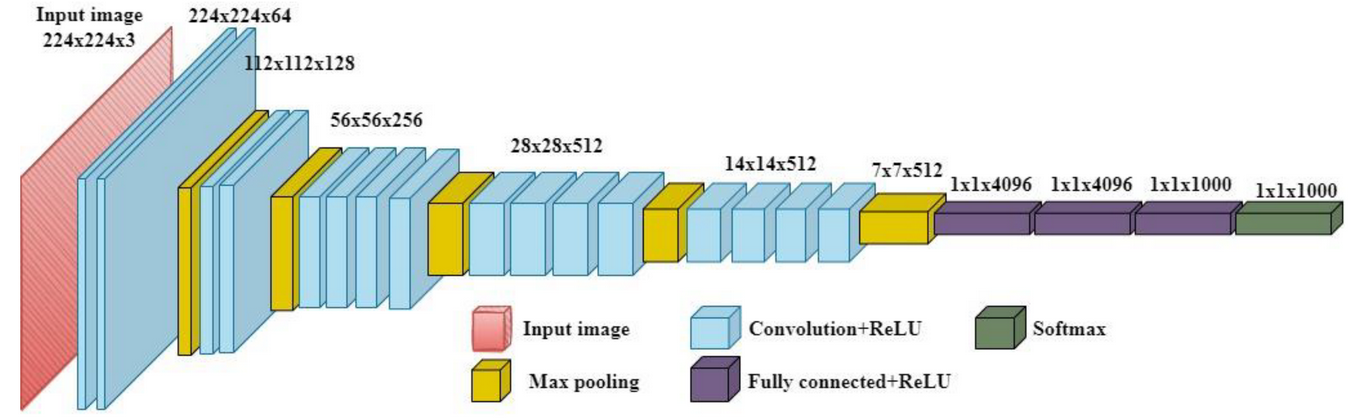
### *Рис.1: Модель на основі VGG-19 архітектури.*

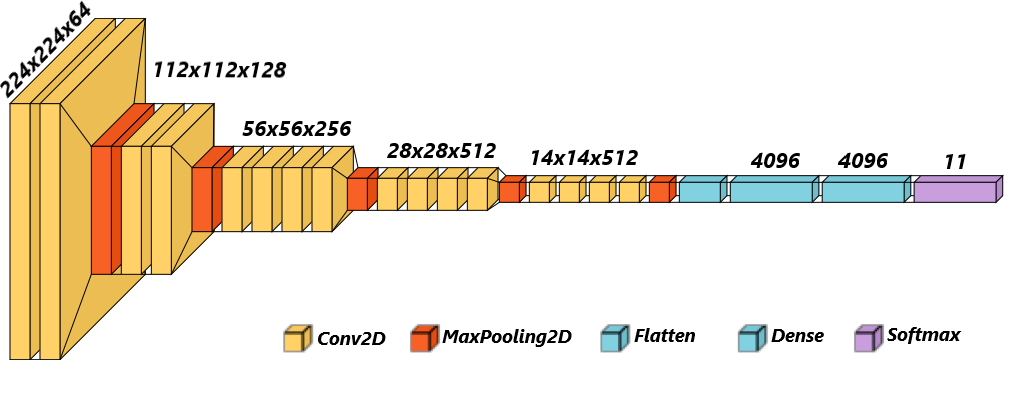
### *Рис.2: Модель на основі VGG-19 архітектури, використана у поданій роботі.*

## Loading and Preprocessing CIFAR-100 dataset

Натомість набір даних CIFAR-100 також містить 60000 зображень розміром 32х32 пікселі у форматі RGB, з яких 50000 відведені для тренування, а 10000 -- для тестування моделі. Однак в даному випадку класифікація відбувається на 100 класів, тобто кожен клас містить 600 зображень. Кожен з цих класів, які також вважаються "спеціальними" $\,$ класами (fine labels), розподіляються між 20 "загальними" $\,$ суперкласами (coarse labels). Для проведення досліджень набір даних CIFAR-10 було використано у ролі головного. Натомість зображення з трьох суперкласів у CIFAR-100 датасеті, а саме "побутові електроприлади" $\,$ (household electrical devices), "харчові контейнери" $\,$ (food containers) та "побутові меблі" $\,$ (household furniture), було використано для відображення надлишкових даних. Кожен зі згаданих суперкласів містить зображення з 5 загальних класів. В результаті 9000 зображень, з яких 7500 для тренування та 1500 для тестування, виконували роль допоміжних при класифікації розглянутих моделей. Всі зображення з CIFAR-10 та CIFAR-100 датасетів під час препроцесингу були нормалізовані та перетворені у формат 64х64 пікселі.

In [3]:
img_height = 64
img_width = 64

def preprocess_cifar(X_cifar, X_cifar_test):
    # Assuming type is bfloat16
    X_cifar = X_cifar.astype('bfloat16')   #COMMENTED 04.02
    X_cifar_test = X_cifar_test.astype('bfloat16')
    
    # Normalize images for better processing (values in range [0; 1])
    X_cifar = X_cifar / 255
    X_cifar_test = X_cifar_test / 255
    
    # Resize images from 32x32 to 64x64 (returns EagerTensor type)
    X_cifar = tf.image.resize_with_pad(
        image=X_cifar,
        target_height=img_height, 
        target_width=img_width,
        method='nearest',
    )
    X_cifar_test = tf.image.resize_with_pad(
        image=X_cifar_test,
        target_height=img_height, 
        target_width=img_width,
        method='nearest',
    )

    # Convert EagerTensor to numpy array
    X_cifar = X_cifar.numpy()
    X_cifar_test = X_cifar_test.numpy()
    
    return X_cifar, X_cifar_test

In [4]:
(X_cifar100, y_cifar100), (X_cifar100_test, y_cifar100_test) = tf.keras.datasets.cifar100.load_data(label_mode='coarse')

X_cifar100, X_cifar100_test = preprocess_cifar(X_cifar100, X_cifar100_test)

from IPython.display import clear_output
clear_output()

In [5]:
print(f"X_cifar100 shape: {X_cifar100.shape}")
print(f"y_cifar100 shape: {y_cifar100.shape}")
print(f"X_cifar100_test shape: {X_cifar100_test.shape}")
print(f"y_cifar100_test shape: {y_cifar100_test.shape}")

X_cifar100 shape: (50000, 64, 64, 3)
y_cifar100 shape: (50000, 1)
X_cifar100_test shape: (10000, 64, 64, 3)
y_cifar100_test shape: (10000, 1)


In [6]:
y_cifar100 = np.squeeze(y_cifar100)
y_cifar100_test = np.squeeze(y_cifar100_test)

In [7]:
# food containers, household electrical devices, household furniture as redundant data => 3 coarse classes => 15 fine classes with 600 images each => 9000
indeces_for_y_cifar100 = np.argwhere((y_cifar100 == 3) | (y_cifar100 == 5) | (y_cifar100 == 6))  
indeces_for_y_cifar100_test = np.argwhere((y_cifar100_test == 3) | (y_cifar100_test == 5) | (y_cifar100_test == 6))

indeces_for_y_cifar100 = np.squeeze(indeces_for_y_cifar100)
indeces_for_y_cifar100_test = np.squeeze(indeces_for_y_cifar100_test)

# change label of redundant data to 10 for future concatenation 
np.put_along_axis(y_cifar100, indeces_for_y_cifar100, 10, axis=0)        
np.put_along_axis(y_cifar100_test, indeces_for_y_cifar100_test, 10, axis=0)

X_cifar100 = np.take(X_cifar100, indeces_for_y_cifar100, axis=0)
y_cifar100 = np.take(y_cifar100, indeces_for_y_cifar100, axis=0)

X_cifar100_test = np.take(X_cifar100_test, indeces_for_y_cifar100_test, axis=0)
y_cifar100_test = np.take(y_cifar100_test, indeces_for_y_cifar100_test, axis=0)

In [8]:
print(f"X_cifar100 shape: {X_cifar100.shape}")
print(f"y_cifar100 shape: {y_cifar100.shape}")
print(f"X_cifar100_test shape: {X_cifar100_test.shape}")
print(f"y_cifar100_test shape: {y_cifar100_test.shape}")

X_cifar100 shape: (7500, 64, 64, 3)
y_cifar100 shape: (7500,)
X_cifar100_test shape: (1500, 64, 64, 3)
y_cifar100_test shape: (1500,)


## Loading and Preprocessing cifar dataset

Набір даних CIFAR-10 містить 60000 зображень розміром 32х32 пікселі у форматі RGB з 10 різних класів ("літак" $\,$, "автомобіль" $\,$, "птах" $\,$, "кіт" $\,$, "олень" $\,$, "собака" $\,$, "жаба" $\,$, "кінь" $\,$, "корабель" $\,$, "вантажний автомобіль" $\,$). Множина тренувальних даних містить вього 50000 зображень, множина тестувальних даних -- 10000 зображень.

In [9]:
(X_cifar, y_cifar), (X_cifar_test, y_cifar_test) = tf.keras.datasets.cifar10.load_data()

X_cifar, X_cifar_test = preprocess_cifar(X_cifar, X_cifar_test)

from IPython.display import clear_output
clear_output()

In [10]:
print(f"X_cifar shape: {X_cifar.shape}")
print(f"y_cifar shape: {y_cifar.shape}")
print(f"X_cifar_test shape: {X_cifar_test.shape}")
print(f"y_cifar_test shape: {y_cifar_test.shape}")

X_cifar shape: (50000, 64, 64, 3)
y_cifar shape: (50000, 1)
X_cifar_test shape: (10000, 64, 64, 3)
y_cifar_test shape: (10000, 1)


In [11]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [12]:
X_cifar[0].min(), X_cifar[0].max()

(0, 1)

### Function to define VGG-19 Architecture

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
import keras.backend as K

def get_vgg19_model():
    return keras.Sequential([
        # Convolutional base for feature extraction 
        # Block One
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape_cifar),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Block Two
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Block Three
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Block Four
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Block Five
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Head of dense (fully connected) layers for classification
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(num_of_classes, activation='softmax'),
    ])

## Concatenation of cifar and cifar-100 datasets

In [14]:
y_cifar = np.squeeze(y_cifar)
y_cifar_test = np.squeeze(y_cifar_test)

In [15]:
X = np.concatenate((X_cifar, X_cifar100), axis=0)
y = np.concatenate((y_cifar, y_cifar100), axis=0)

X_test = np.concatenate((X_cifar_test, X_cifar100_test), axis=0)
y_test = np.concatenate((y_cifar_test, y_cifar100_test), axis=0)

# Shuffle concatenated validation and testing features and targets simultaneously
X, y = shuffle(X, y)
X_test, y_test = shuffle(X_test, y_test)

In [16]:
print(f'Train: X={X.shape}, y={y.shape}')
print(f'Test: X={X_test.shape}, y={y_test.shape}')

Train: X=(57500, 64, 64, 3), y=(57500,)
Test: X=(11500, 64, 64, 3), y=(11500,)


## Building a model

In [17]:
num_of_classes = len(np.unique(y))
num_of_classes

11

Оскільки дані у prediction target подані як цілі числа [0, 10], які репрезентують відповідні цифри на фотографіях (classification), є два шляхи опрацювання та побудови моделі. З одного боку, можна залишити все як є та вважати, що ми працюємо з виконаним ordinal encoding. З іншого боку, можна використати onehot encoding, з допомогою якого буде створено 10 нових стовпців, кожен з яких буде представляти цифру. Таким чином кожна фотографія буде мітисти 10-елементний вектор, кожне значення якого буде вказувати яку цифру представляє фотографія. 

In [18]:
y = to_categorical(y)
y_test = to_categorical(y_test)

print(f'y_one_hot: train={y.shape}')

y_one_hot: train=(57500, 11)


In [19]:
input_shape_cifar = X.shape[1:]
input_shape_cifar

(64, 64, 3)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [21]:
vgg_19_model_onehot = get_vgg19_model()

In [22]:
vgg_19_model_onehot.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
vgg_19_model_onehot.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       2

In [23]:
history_vgg19_onehot_omniglot_and_cifar = vgg_19_model_onehot.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=5,
)

Epoch 1/5
719/719 [==============================] - 91s 109ms/step - loss: 2.3869 - accuracy: 0.1307 - val_loss: 2.3682 - val_accuracy: 0.1290
Epoch 2/5
719/719 [==============================] - 79s 109ms/step - loss: 2.0894 - accuracy: 0.2475 - val_loss: 1.9349 - val_accuracy: 0.3002
Epoch 3/5
719/719 [==============================] - 79s 109ms/step - loss: 1.8251 - accuracy: 0.3409 - val_loss: 1.6774 - val_accuracy: 0.3890
Epoch 4/5
719/719 [==============================] - 79s 109ms/step - loss: 1.5825 - accuracy: 0.4350 - val_loss: 1.5190 - val_accuracy: 0.4558
Epoch 5/5
719/719 [==============================] - 79s 109ms/step - loss: 1.3581 - accuracy: 0.5227 - val_loss: 1.2522 - val_accuracy: 0.5588


In [24]:
score_onehot_omniglot_and_cifar = vgg_19_model_onehot.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_onehot_omniglot_and_cifar[0])
print('Test score:', score_onehot_omniglot_and_cifar[1])

print("CNN Error: %.2f%%" % (100-score_onehot_omniglot_and_cifar[1]*100))

Test loss: 1.2697111368179321
Test score: 0.5547826290130615
CNN Error: 44.52%


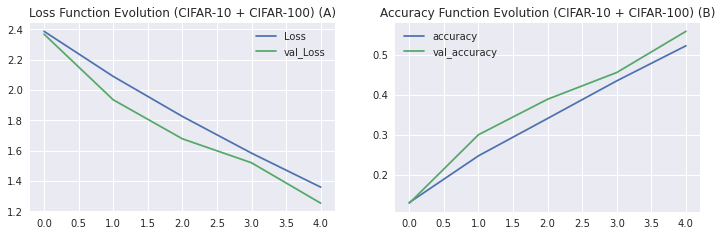

In [25]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history_vgg19_onehot_omniglot_and_cifar.history['loss'], label='Loss')
plt.plot(history_vgg19_onehot_omniglot_and_cifar.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution (CIFAR-10 + CIFAR-100) (A)')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_vgg19_onehot_omniglot_and_cifar.history['accuracy'], label='accuracy')
plt.plot(history_vgg19_onehot_omniglot_and_cifar.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution (CIFAR-10 + CIFAR-100) (B)')
plt.legend()

## Prediction and Confusion Matrix

### Measure average inference time for 1 sample
----

In [26]:
# GPU T4 x2, batch_size = 32 (default)
import time
start_time = time.time()

#Predict y_test values for comparison in confusion matrix (omniglot + cifar, 11 classes)
y_test_pred = vgg_19_model_onehot.predict(X_test)

elapsed = time.time() - start_time

print(f"Inference time for all samples: {np.round(elapsed, 6)} sec.\nAverage inference time for 1 sample (omniglot + cifar dataset, 11 classes): {np.round(elapsed / len(X_test), 6)} sec.")

Inference time for all samples: 10.961303 sec.
Average inference time for 1 sample (omniglot + cifar dataset, 11 classes): 0.000953 sec.


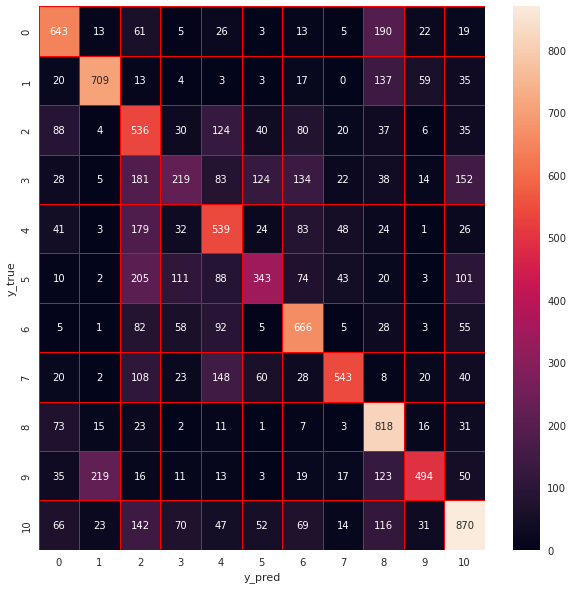

In [27]:
#Confusion matrix for cifar + omniglot evaluation data
omniglot_cifar_cm=confusion_matrix(y_test.argmax(axis=1), y_test_pred.argmax(axis=1))

f, ax=plt.subplots(figsize=(10,10))
sns.heatmap(omniglot_cifar_cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [28]:
print(classification_report(y_test.argmax(axis=1), y_test_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63      1000
           1       0.71      0.71      0.71      1000
           2       0.35      0.54      0.42      1000
           3       0.39      0.22      0.28      1000
           4       0.46      0.54      0.50      1000
           5       0.52      0.34      0.41      1000
           6       0.56      0.67      0.61      1000
           7       0.75      0.54      0.63      1000
           8       0.53      0.82      0.64      1000
           9       0.74      0.49      0.59      1000
          10       0.62      0.58      0.60      1500

    accuracy                           0.55     11500
   macro avg       0.57      0.55      0.55     11500
weighted avg       0.57      0.55      0.55     11500



### Other metrics nad results

In [29]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
labels.append("Household")

def plot_image(i, predictions_array, true_array, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_array):
    plt.grid(False)
    plt.xticks(range(11))
    plt.yticks([])
    thisplot = plt.bar(range(11), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

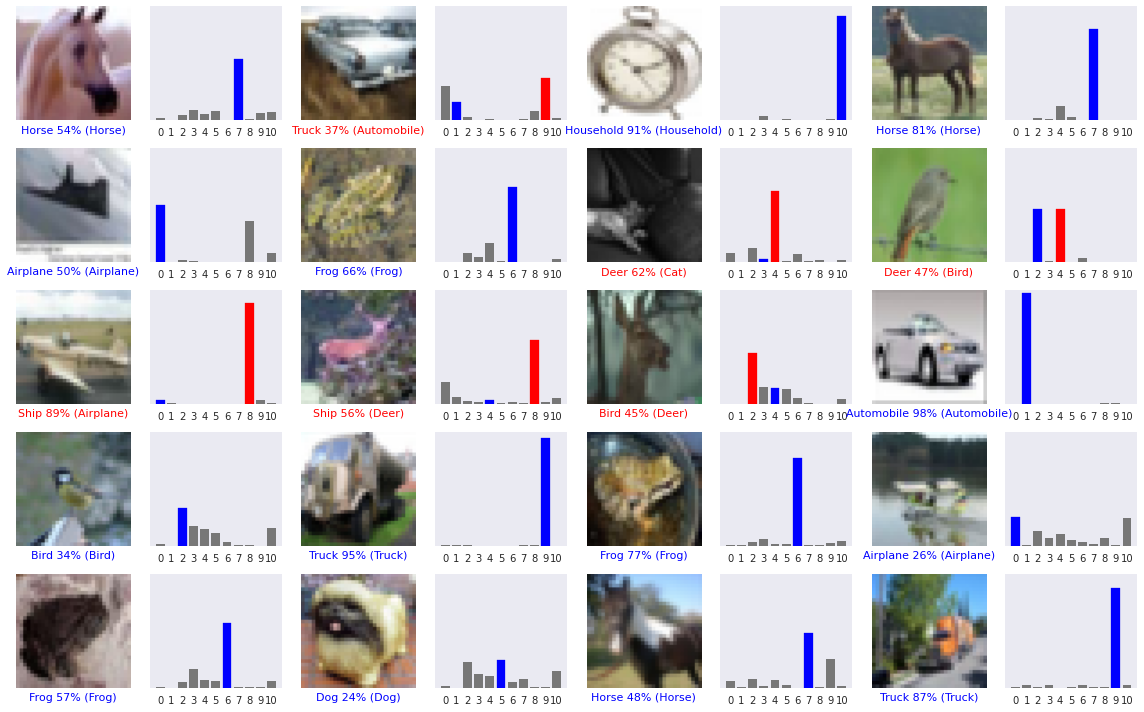

In [30]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
X_test = X_test.astype("float32")
num_rows = 5
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, y_test_pred[i+20], y_test[i+20], X_test[i+20])
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_test_pred[i+20], y_test[i+20])
plt.tight_layout()
plt.show()